# GemPy Paper Code: UQ

In this notebook you will be able to see and run the code utilized to create the figures of the paper *GemPy - an open-source library for implicit geological modeling and uncertainty quantification*

In [1]:
# Importing dependencies

# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

import gempy as gp
%matplotlib inline
from copy import copy, deepcopy
# Aux imports

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Uncertainty Quatification.

In this model we will explore how to create a model of GemPy with PyMC which some of the parameters are stochastic  in order to quatify the uncertainty that those parameters propagate to the final results.

We will use the same model as until now

In [2]:
geo_data = gp.create_data([0,20,0,10,-10,0],[100,10,100],
                         path_o = "input_data/paper_Orientations.csv",
                         path_i = "input_data/paper_Points.csv")

In [3]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,formation_number,order_series,isFault,annotations,formation_value
6,2.211584,5.0,-6.400000,Layer1,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",1
7,11.172574,5.0,-6.981171,Layer1,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",1
8,15.104438,5.0,-8.108915,Layer1,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",1
9,2.059186,5.0,-4.908561,Layer2,Default series,2,1,False,"${\bf{x}}_{\alpha \,{\bf{2}},0}$",2
10,11.843125,5.0,-5.761989,Layer2,Default series,2,1,False,"${\bf{x}}_{\alpha \,{\bf{2}},1}$",2


Defining all different series that form the most complex model. In the paper you can find figures with different combination of these series to examplify the possible types of topolodies supported in GemPy

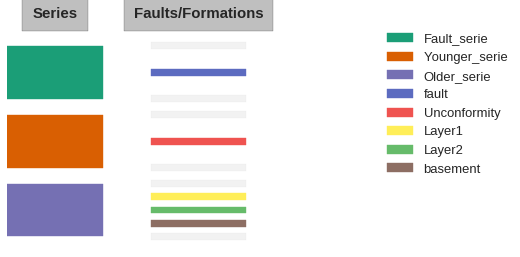

In [4]:
%matplotlib inline
gp.set_series(geo_data, {'Fault_serie': 'fault',
                         'Younger_serie' : 'Unconformity',
                         'Older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault', 'Unconformity',
                                 'Layer2', 'Layer1'],
              verbose=2)


fig=plt.gcf()
# fig.savefig('doc/figs/fault_pile.pdf')

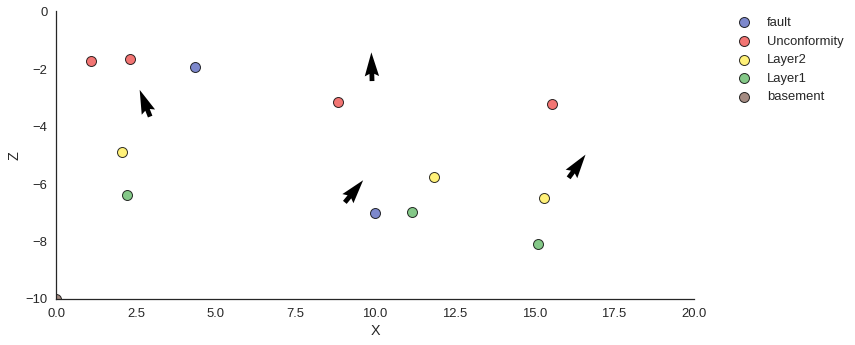

In [5]:
gp.plotting.plot_data(geo_data, direction="y")

In [6]:
interp_data = gp.InterpolatorData(geo_data,
                                  dtype='float64',
                                  compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


Computing the model

In [7]:
lith, fault = gp.compute_model(interp_data)

## Topology

compute the initial topology for use in the topology likelihood function

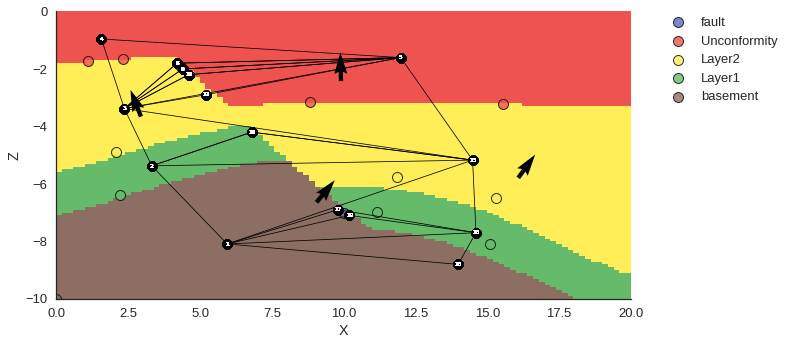

In [8]:
topo = gp.topology_compute(geo_data, lith[0], fault)
gp.plotting.plot_section(geo_data, lith[0], 0, plot_data=True)
gp.plotting.plot_topology(geo_data, topo[0], topo[1])
# save topology state for likelihood use
topo_G = copy(topo[0])

# PYMC2 Code

In [9]:
import pymc

## Priors

In [10]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,formation_number,order_series,isFault,annotations,formation_value
0,10.000000,4.0,-7.000000,fault,Fault_serie,1,1,True,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",1
1,4.345153,5.0,-1.921564,fault,Fault_serie,1,1,True,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",1
2,2.303022,5.0,-1.647248,Unconformity,Younger_serie,2,2,False,"${\bf{x}}_{\alpha \,{\bf{2}},0}$",2
3,1.083840,5.0,-1.738687,Unconformity,Younger_serie,2,2,False,"${\bf{x}}_{\alpha \,{\bf{2}},1}$",2
4,8.825648,5.0,-3.140747,Unconformity,Younger_serie,2,2,False,"${\bf{x}}_{\alpha \,{\bf{2}},2}$",2


In [11]:
#from gempy.UncertaintyAnalysisPYMC2 import modify_plane_dip
from copy import deepcopy
import pymc

First we store the original object with the data (rescaled)

In [12]:
geo_data_stoch_init = deepcopy(interp_data.geo_data_res)

In [13]:
interp_data.geo_data_res.interfaces.tail()

,X,Y,Z,formation,series,formation_number,order_series,isFault,annotations,formation_value
7,0.618357,0.577837,0.502017,Layer2,Older_serie,3,3,False,"${\bf{x}}_{\alpha \,{\bf{3}},1}$",3
8,0.726401,0.577837,0.479271,Layer2,Older_serie,3,3,False,"${\bf{x}}_{\alpha \,{\bf{3}},2}$",3
9,0.318868,0.577837,0.482178,Layer1,Older_serie,4,3,False,"${\bf{x}}_{\alpha \,{\bf{4}},0}$",4
10,0.597507,0.577837,0.464107,Layer1,Older_serie,4,3,False,"${\bf{x}}_{\alpha \,{\bf{4}},1}$",4
11,0.719767,0.577837,0.429040,Layer1,Older_serie,4,3,False,"${\bf{x}}_{\alpha \,{\bf{4}},2}$",4


Rescaling the std we want to give to the input data:

In [14]:
0.3/interp_data.rescaling_factor

0.009328383734383354

The first step is to define the pdf which describe our priors. In this case we will add noise to the interfaces of 0.3 (0.01 rescaled).

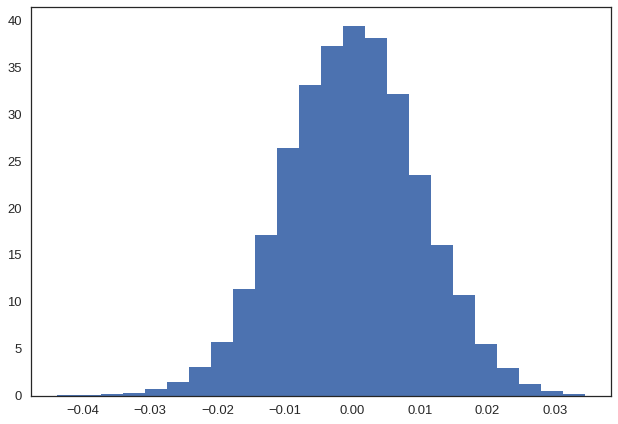

In [15]:
# Positions (rows) of the data we want to make stochastic
ids = range(2,12)

# List with the stochastic parameters 
interface_Z_modifier = [pymc.Normal("interface_Z_mod_"+str(i), 0., 1./0.01**2) for i in ids]

# Plotting the first element of the list
samples = [interface_Z_modifier[0].rand() for i in range(10000)]
plt.hist(samples, bins=24, normed=True);

To store the value of the input data---i.e. the value x at every each iteration---we need to wrap the process inside a detereministic decorator of pymc2:

In [16]:
geo_data.interfaces.loc[2, 'Z'] + interface_Z_modifier[2].rand()

-1.6597735520170793

In [17]:
ids

range(2, 12)

In [18]:
gp.get_data(geo_data_stoch_init, numeric=True)

X         Y         Z       G_x           G_y  \
interfaces   0   0.561046  0.546742  0.463521       NaN           NaN   
             1   0.385211  0.577837  0.621433       NaN           NaN   
             2   0.321712  0.577837  0.629963       NaN           NaN   
             3   0.283802  0.577837  0.627120       NaN           NaN   
             4   0.524530  0.577837  0.583523       NaN           NaN   
             5   0.733983  0.577837  0.580680       NaN           NaN   
             6   0.314130  0.577837  0.528554       NaN           NaN   
             7   0.618357  0.577837  0.502017       NaN           NaN   
             8   0.726401  0.577837  0.479271       NaN           NaN   
             9   0.318868  0.577837  0.482178       NaN           NaN   
             10  0.597507  0.577837  0.464107       NaN           NaN   
             11  0.719767  0.577837  0.429040       NaN           NaN   
orientations 1   0.531629  0.577837  0.474529  0.637572  1.000039e-12   
             2   0.558184  0.577837  0.605861 -0.023246  9.999957e-13   
             3   0.341610  0.577837  0.567408 -0.365657  9.999328e-13   
             0   0.750100  0.577837  0.501083  0.588166  1.000036e-12   

                      G_z     dip  azimuth  polarity  
interfaces   0        NaN     NaN      NaN       NaN  
             1        NaN     NaN      NaN       NaN  
             2        NaN     NaN      NaN       NaN  
             3        NaN     NaN      NaN       NaN  
             4        NaN     NaN      NaN       NaN  
             5        NaN     NaN      NaN       NaN  
             6        NaN     NaN      NaN       NaN  
             7        NaN     NaN      NaN       NaN  
             8        NaN     NaN      NaN       NaN  
             9        NaN     NaN      NaN       NaN  
             10       NaN     NaN      NaN       NaN  
             11       NaN     NaN      NaN       NaN  
orientations 1   0.770391  39.611     90.0       1.0  
             2   0.999730   1.332    270.0       1.0  
             3   0.930750  21.448    270.0       1.0  
             0   0.808740  36.027     90.0       1.0

## Deterministic functions

In [19]:
@pymc.deterministic(trace=True)
def input_data(value = 0, 
               interface_Z_modifier = interface_Z_modifier,
               geo_data_stoch_init = geo_data_stoch_init,
               ids = ids,
               verbose=1):
    # First we extract from our original intep_data object the numerical data
    #that is necessary for the interpolation.
    
    # geo_data_stoch is a pandas Dataframe
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    
    # Now we loop each id which share the same uncertainty variable. In this case, each layer.
    for e, i in enumerate(ids):
        # We add the stochastic part to the initial value
        #new_val = (geo_data_stoch_init.interfaces.loc[i, "Z"] + interface_Z_modifier[num])
        # print(new_val)
        #interp_data.geo_data_res.interfaces.iat[i, 2] = new_val
        geo_data_stoch.xs('interfaces').loc[i, 'Z'] += np.array(interface_Z_modifier[e])
        
        
    if verbose > 0:
        print(geo_data_stoch)
        print(interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].values)
        
    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
    # We need to save the data as numpy arrays
    return  [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values,
             geo_data_stoch.xs('orientations').values]

                        X         Y         Z       G_x           G_y  \
interfaces   0   0.561046  0.546742  0.463521       NaN           NaN   
             1   0.385211  0.577837  0.621433       NaN           NaN   
             2   0.321712  0.577837  0.639762       NaN           NaN   
             3   0.283802  0.577837  0.624947       NaN           NaN   
             4   0.524530  0.577837  0.570997       NaN           NaN   
             5   0.733983  0.577837  0.589425       NaN           NaN   
             6   0.314130  0.577837  0.517404       NaN           NaN   
             7   0.618357  0.577837  0.495990       NaN           NaN   
             8   0.726401  0.577837  0.473314       NaN           NaN   
             9   0.318868  0.577837  0.477124       NaN           NaN   
             10  0.597507  0.577837  0.455398       NaN           NaN   
             11  0.719767  0.577837  0.427584       NaN           NaN   
orientations 1   0.531629  0.577837  0.474529  0.63

In [58]:
# %matplotlib notebook
@pymc.deterministic(trace=True)
def gempy_model(value=0,
                input_data=input_data, verbose=False):
    
    # modify input data values accordingly
    interp_data.geo_data_res_no_basement.interfaces[["X", "Y", "Z"]] = input_data[0]
    
    # Gx, Gy, Gz are just used for visualization. The theano function gets azimuth dip and polarity!!!
    interp_data.geo_data_res_no_basement.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z", 'dip', 'azimuth', 'polarity']] = input_data[1]
    print(interp_data.geo_data_res_no_basement.interfaces[["X", "Y", "Z"]])
    try:
        # try to compute model
        lb, fb = gp.compute_model(interp_data)
        if verbose:
            gp.plot_section(interp_data.geo_data_res, lb[0], 5, plot_data=True)
        #    gp.plot_data(interp_data.geo_data_res, direction='y')

        return lb, fb
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_block), np.zeros_like(fault_block)

AttributeError: 'InterpolatorData' object has no attribute 'geo_data_res_no_basement'

In [21]:
@pymc.deterministic(trace=True)
def gempy_surfaces(value=0, gempy_model=gempy_model):
    vert, simp = gp.get_surfaces(interp_data, gempy_model[0][1], gempy_model[1][1], original_scale=True)
    return vert

Potential field of the surface is outside the block. Probably is due to float errors


## Likelihood functions

## pymc Model

In [22]:
# We add all the pymc objects to a list
params = [input_data, gempy_model, gempy_surfaces, *interface_Z_modifier] 

# We create the pymc model i.e. the probabilistic graph
model = pymc.Model(params)

Create pymc probabilistic graph plot:

In [23]:
graph = pymc.graph.dag(model)
graph.write_png('figures/paper_graph.png')

True

Running inference:

In [24]:
runner = pymc.MCMC(model, db="hdf5", dbname="pymc-db/UQ.hdf5")

In [25]:
iterations = 5

In [26]:
runner.use_step_method(pymc.AdaptiveMetropolis, params, delay=10)
np.random.seed(34)
runner.sample(iterations, tune_interval=1000, tune_throughout=True, )

                        X         Y         Z       G_x           G_y  \
interfaces   0   0.561046  0.546742  0.463521       NaN           NaN   
             1   0.385211  0.577837  0.621433       NaN           NaN   
             2   0.321712  0.577837  0.634208       NaN           NaN   
             3   0.283802  0.577837  0.625591       NaN           NaN   
             4   0.524530  0.577837  0.571620       NaN           NaN   
             5   0.733983  0.577837  0.575570       NaN           NaN   
             6   0.314130  0.577837  0.536460       NaN           NaN   
             7   0.618357  0.577837  0.494866       NaN           NaN   
             8   0.726401  0.577837  0.505177       NaN           NaN   
             9   0.318868  0.577837  0.469605       NaN           NaN   
             10  0.597507  0.577837  0.470000       NaN           NaN   
             11  0.719767  0.577837  0.427102       NaN           NaN   
orientations 1   0.531629  0.577837  0.474529  0.63

Potential field of the surface is outside the block. Probably is due to float errors
 [-----------------80%----------        ] 4 of 5 complete in 2.4 sec                        X         Y         Z       G_x           G_y  \
interfaces   0   0.561046  0.546742  0.463521       NaN           NaN   
             1   0.385211  0.577837  0.621433       NaN           NaN   
             2   0.321712  0.577837  0.628573       NaN           NaN   
             3   0.283802  0.577837  0.645753       NaN           NaN   
             4   0.524530  0.577837  0.578509       NaN           NaN   
             5   0.733983  0.577837  0.579344       NaN           NaN   
             6   0.314130  0.577837  0.535305       NaN           NaN   
             7   0.618357  0.577837  0.505675       NaN           NaN   
             8   0.726401  0.577837  0.472479       NaN           NaN   
             9   0.318868  0.577837  0.502381       NaN           NaN   
             10  0.597507  0.577837  0.47141

Computing the initial model:

In [27]:
lb, fb = gp.compute_model(interp_data)

In [28]:
v_l, s_l = gp.get_surfaces(interp_data, lb[1], fb[1], original_scale=True)

Potential field of the surface is outside the block. Probably is due to float errors


In [29]:
geo_data.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault,annotations,formation_value
1,9.053956,5,-6.646000,0.637572,1.000039e-12,0.770391,39.611,90,1,fault,Fault_serie,1,1,True,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1
2,9.907953,5,-2.422365,-0.023246,9.999957e-13,0.999730,1.332,270,1,Unconformity,Younger_serie,2,2,False,"${\bf{x}}_{\beta \,{\bf{2}},0}$",2
3,2.942956,5,-3.659000,-0.365657,9.999328e-13,0.930750,21.448,270,1,Layer2,Older_serie,3,3,False,"${\bf{x}}_{\beta \,{\bf{3}},0}$",3
0,16.079956,5,-5.792000,0.588166,1.000036e-12,0.808740,36.027,90,1,Layer1,Older_serie,4,3,False,"${\bf{x}}_{\beta \,{\bf{4}},0}$",4


In [30]:
gp.plotting.plot_surfaces_3D(geo_data, v_l, s_l, alpha=1)

closing vtk


In [31]:
vertices = runner.trace("gempy_surfaces")[:]

Reading traces:

In [45]:
runner.trace("gempy_model")[0][0]

array([[    4.8151856 ,     4.80778205,     4.8001171 , ...,
            2.        ,     2.        ,     2.        ],
       [ 1079.92944336,  1079.93408203,  1079.9387207 , ...,
           31.5172081 ,    31.52306557,    31.52892113]])

In [46]:
runner.trace("gempy_model")[1][0]

array([[    4.8151856 ,     4.80778205,     4.8001171 , ...,
            2.        ,     2.        ,     2.        ],
       [ 1079.92944336,  1079.93408203,  1079.9387207 , ...,
           31.5172081 ,    31.52306557,    31.52892113]])

In [48]:
runner.trace('input_data')[0]

array([ array([[ 0.56104612,  0.54674192,  0.46352104],
       [ 0.38521085,  0.57783653,  0.62143304],
       [ 0.32171158,  0.57783653,  0.63420765],
       [ 0.28380158,  0.57783653,  0.62559088],
       [ 0.5245301 ,  0.57783653,  0.57161978],
       [ 0.73398289,  0.57783653,  0.57556983],
       [ 0.31412959,  0.57783653,  0.53646023],
       [ 0.61835738,  0.57783653,  0.49486615],
       [ 0.7264009 ,  0.57783653,  0.50517697],
       [ 0.31886835,  0.57783653,  0.46960496],
       [ 0.59750686,  0.57783653,  0.47000002],
       [ 0.71976665,  0.57783653,  0.42710186]]),
       array([[  5.31629253e-01,   5.77836531e-01,   4.74528537e-01,
          6.37571906e-01,   1.00003904e-12,   7.70390852e-01,
          3.96110000e+01,   9.00000000e+01,   1.00000000e+00],
       [  5.58183959e-01,   5.77836531e-01,   6.05860830e-01,
         -2.32456916e-02,   9.99995730e-13,   9.99729782e-01,
          1.33200000e+00,   2.70000000e+02,   1.00000000e+00],
       [  3.41610076e-01,   5.778

In [49]:
runner.trace('input_data')[3]

array([ array([[ 0.56104612,  0.54674192,  0.46352104],
       [ 0.38521085,  0.57783653,  0.62143304],
       [ 0.32171158,  0.57783653,  0.62857299],
       [ 0.28380158,  0.57783653,  0.64575332],
       [ 0.5245301 ,  0.57783653,  0.57850864],
       [ 0.73398289,  0.57783653,  0.57934392],
       [ 0.31412959,  0.57783653,  0.53530473],
       [ 0.61835738,  0.57783653,  0.50567522],
       [ 0.7264009 ,  0.57783653,  0.47247892],
       [ 0.31886835,  0.57783653,  0.50238133],
       [ 0.59750686,  0.57783653,  0.47141427],
       [ 0.71976665,  0.57783653,  0.42696126]]),
       array([[  5.31629253e-01,   5.77836531e-01,   4.74528537e-01,
          6.37571906e-01,   1.00003904e-12,   7.70390852e-01,
          3.96110000e+01,   9.00000000e+01,   1.00000000e+00],
       [  5.58183959e-01,   5.77836531e-01,   6.05860830e-01,
         -2.32456916e-02,   9.99995730e-13,   9.99729782e-01,
          1.33200000e+00,   2.70000000e+02,   1.00000000e+00],
       [  3.41610076e-01,   5.778

In [52]:
interp_data.geo_data_res.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault,annotations,formation_value
1,0.637572,1.000039e-12,0.770391,0.531629,0.577837,0.474529,39.611,90.0,1.0,fault,Fault_serie,1,1,True,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1
2,-0.023246,9.999957e-13,0.999730,0.558184,0.577837,0.605861,1.332,270.0,1.0,Unconformity,Younger_serie,2,2,False,"${\bf{x}}_{\beta \,{\bf{2}},0}$",2
3,-0.365657,9.999328e-13,0.930750,0.341610,0.577837,0.567408,21.448,270.0,1.0,Layer2,Older_serie,3,3,False,"${\bf{x}}_{\beta \,{\bf{3}},0}$",3
0,0.588166,1.000036e-12,0.808740,0.750100,0.577837,0.501083,36.027,90.0,1.0,Layer1,Older_serie,4,3,False,"${\bf{x}}_{\beta \,{\bf{4}},0}$",4


In [37]:
(runner.trace("gempy_model")[1][1] == runner.trace("gempy_model")[4][1]).sum(axis=1)

array([100000, 100000])

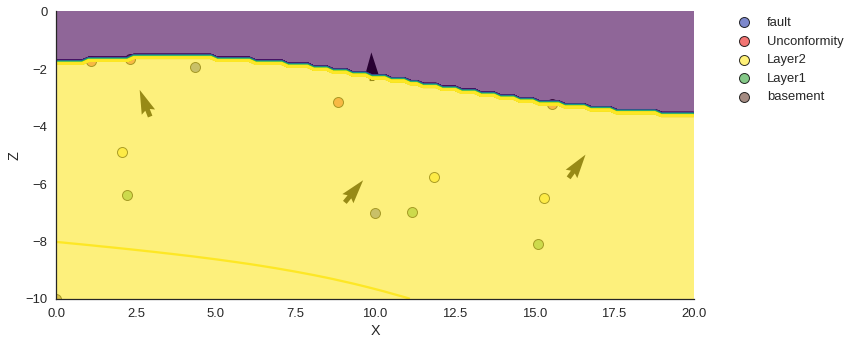

In [33]:
gp.plotting.plot_scalar_field(geo_data, runner.trace("gempy_model")[2][0][1], 5,
                              N=500, cmap='viridis')

In [53]:
# Function to plot the traces with the vertices
def plot_iterline(i, l, color="black", lw=0.5):
    f = vertices[i, l][:,1]==np.min(vertices[i, l][:,1])
   # f = a
    
    points = vertices[i, l][f]
    plt.plot(points[::5,0], points[::5,2], '-',
             #linestyle="solid",
             linewidth=lw, color=color, alpha=0.3)


In [54]:
# Some plotting options
params = {
    'axes.labelsize': 6,
    'font.size': 6,
    'legend.fontsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'text.usetex': False,
    "axes.linewidth": 0.75,
    'xtick.major.size': 2,
    'xtick.major.width': 0.75,
    'ytick.major.size': 2,
    'ytick.major.width': 0.75,
}


def get_figsize(scale, textwidth=522, ratio=None):                      # Get this from LaTeX using \the\textwidth
    """Source: http://bkanuka.com/articles/native-latex-plots/"""
    inches_per_pt = 1.0 / 72.27                             # Convert pt to inch
    if ratio == None:
        ratio = (np.sqrt(5.0)-1.0)/2.0                    # Aesthetic ratio (you could change this)
    fig_width = textwidth * inches_per_pt * scale           # width in inches
    fig_height = fig_width * ratio                    # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

from matplotlib import rcParams
rcParams.update(params)

IndexError: index 6 is out of bounds for axis 0 with size 5

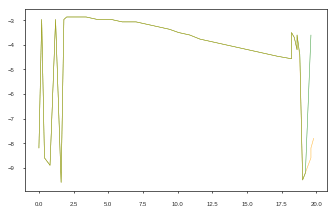

In [55]:
fig = plt.figure(figsize=get_figsize(0.75))
ax = plt.subplot()
    
for i in range(0,100,2):
    plot_iterline(i, 3, color="green")
    plot_iterline(i, 2, color="orange")
    plot_iterline(i, 1, color="red")
    # plot_iterline(i, 0, color="black", lw=2)
    
ax.set_xlabel("x")

plt.legend()
plt.ylabel("z")
plt.xlim(0,19)
ax.set_xticks(np.arange(0, 20, 5))
plt.ylim(-10,-0)
plt.plot([2., 13.3], [0,-10], color="gray", linewidth=4)
plt.grid(False)

#plt.title("Stochastic simulation of layer interfaces");

#plt.savefig("doc/figs/UQ.pdf", facecolor="white")

IndexError: index 6 is out of bounds for axis 0 with size 5

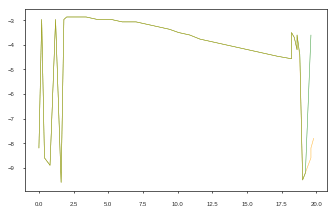

In [56]:
fig = plt.figure(figsize=get_figsize(0.75))
ax = plt.subplot()
    
for i in range(0,100,2):
    plot_iterline(i, 3, color="green")
    plot_iterline(i, 2, color="orange")
    plot_iterline(i, 1, color="red")
    # plot_iterline(i, 0, color="black", lw=2)
    
ax.set_xlabel("x")

plt.legend()
plt.ylabel("z")
plt.xlim(0,19)
ax.set_xticks(np.arange(0, 20, 5))
plt.ylim(-10,-0)
plt.plot([2., 13.3], [0,-10], color="gray", linewidth=4)
plt.grid(False)

#plt.title("Stochastic simulation of layer interfaces");

#plt.savefig("doc/figs/UQ.pdf", facecolor="white")

In [ ]:
gp.plot_section(geo_data, runner.trace("gempy_model")[:][:,0,0,:][30], 5)
plt.savefig('original_model.pdf')

In [ ]:
p_i = gp.pa.calculate_probability_lithology(runner.trace("gempy_model")[:][:,0,0,:])

In [ ]:
gp.plot_section(geo_data,p_i[3], 5, cmap='viridis', norm=None)
plt.colorbar(orientation='horizontal')
#plt.savefig("doc/figs/prob.pdf", facecolor="white")

In [ ]:
e = gp.pa.calcualte_ie_masked(p_i)

In [ ]:
gp.plot_section(geo_data,e, 5, cmap='magma', norm=None)
plt.colorbar(orientation='horizontal')


#plt.savefig("doc/figs/entropy.pdf", facecolor="white")

## Create syntetic gravity for likelihoods

In [ ]:
geo_data_g = gp.create_data([-10e3,30e3,-10e3,20e3,-10e3,0],[50,50,50],
                         path_f = "input_data/paper_Orientations.csv",
                         path_i = "input_data/paper_Points.csv")
geo_data_g.add_interface(X=10, Y=4, Z=-7, formation='fault1')

gp.set_series(geo_data_g, {'fault_serie1': 'fault1','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault1', 'Unconformity', 'Layer2', 'Layer1'], verbose=2)

geo_data_g.modify_interface(9, Z = -6.4)

geo_data_g.interfaces[['X', 'Y', 'Z']] = geo_data_g.interfaces[['X', 'Y', 'Z']]*1000
geo_data_g.orientations[['X', 'Y', 'Z']] = geo_data_g.orientations[['X', 'Y', 'Z']]*1000

# Theano compilation
interp_data_g = gp.InterpolatorData(geo_data_g, u_grade=[3, 3, 3], dtype='float64', verbose=[],  output='gravity')

Change the initial data for the iteration that we want to compute

In [ ]:
trace = 72
# modify input data values accordingly
interp_data_g.geo_data_res.interfaces[["X", "Y", "Z"]] = runner.trace("input_data")[72][0]

# Gx, Gy, Gz are just used for visualization. The theano function gets azimuth dip and polarity!!!
interp_data_g.geo_data_res.orientations[["X", "Y", "Z", 'dip', 'azimuth', 'polarity']] = runner.trace("input_data")[15][1]



In [ ]:
# Set the specific parameters for the measurement grid of gravity:
gp.set_geophysics_obj(interp_data_g,  
                      [0.1e3,19.9e3,.1e3,.9e3, -10e3, 0], # Extent
                      [30,20])                            # Resolution 

# Setting desity and precomputations 
t = gp.precomputations_gravity(interp_data_g, 25,
                         [2.92e6, 3.1e6, 2.61e6, 2.92e6])

In [ ]:
lith, fault, grav = gp.compute_model(interp_data_g, output='gravity')

In [ ]:
# grav_u = np.load('real_grav.npy')

In [ ]:
gp.plot_section(geo_data_g, lith[0], 5, direction='z',plot_data=True)
#annotate_plot(gp.get_data(geo_data_g, verbosity=2), 'annotations', 'X', 'Z', size = 20)
# ax = plt.gca()
# ax.set_xticks(np.linspace(0, 20, 50))
# ax.set_yticks(np.linspace(0, -10, 50))
#plt.grid()
fig = plt.gcf()
ax = plt.gca()
p = ax.imshow(grav.reshape(20,30), cmap='viridis', origin='lower', alpha=0.8, extent=[0,20e3,0,10e3])
# plt.xlim(-2e3,22e3)
# plt.ylim(-2e3,12e3)

plt.xlim(-2e3,22e3)
plt.ylim(-2e3,12e3)

plt.colorbar(p, orientation='horizontal')
#plt.savefig('Initial_grav.pdf')

In [ ]:
gp.plot_section(geo_data_g, lith[0], 5, direction='z',plot_data=True)

plt.grid()
fig = plt.gcf()
ax = plt.gca()
p = ax.imshow(grav.reshape(20,30), cmap='viridis', origin='lower', alpha=0.8, extent=[0,20e3,0,10e3])
# plt.xlim(-2e3,22e3)
# plt.ylim(-2e3,12e3)

plt.xlim(-10e3,30e3)
plt.ylim(-10e3,20e3)

plt.colorbar(p)

In [ ]:
# np.save('real_grav', grav)